In [1]:
import torch as t
import torchvision as tv

In [2]:
# 显示图像函数
from torchvision.transforms import ToPILImage
show = ToPILImage()

In [3]:
# 数据变换
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
# 下载数据集
from torchvision import datasets as dsets
trainsets = dsets.CIFAR10(
    root='/Users/cheewing/code/Pytorch/data/',
    train=True,
    download=True,
    transform=transform
)

testsets = dsets.CIFAR10(
    root='/Users/cheewing/code/Pytorch/data/',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# 导入数据
from torch.utils.data import DataLoader
trainloader = DataLoader(
    trainsets,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

testloader = DataLoader(
    testsets,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

In [6]:
# 数据标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

ship


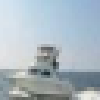

In [8]:
# 测试数据
data, label = trainsets[100]
print(classes[label])
show((data+1)/2).resize((100, 100))

实际的label:  cat frog car bird


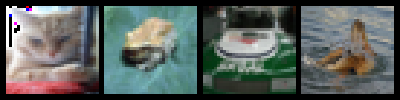

In [18]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('实际的label: ', ' '.join(classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images/2 - 0.5)).resize((400, 100))

In [19]:
# 定义训练网络
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
# 损失函数&优化函数
from torch import nn
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [33]:
# 训练网络
from torch.autograd import Variable as V
t.set_num_threads(8)
for epoch in range(2):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = V(inputs), V(labels)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        outpus = net(inputs)
        
        # 计算损失
        loss = criterion(outpus, labels)
        
        # 反向传播
        loss.backward()
        
        # 参数更新
        optimizer.step()
        
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
        
print('Finished Training')

[1,  2000] loss: 1.058
[1,  4000] loss: 1.089
[1,  6000] loss: 1.073
[1,  8000] loss: 1.088
[1, 10000] loss: 1.046
[1, 12000] loss: 1.101
[2,  2000] loss: 1.002
[2,  4000] loss: 1.021
[2,  6000] loss: 1.036
[2,  8000] loss: 1.039
[2, 10000] loss: 1.056
[2, 12000] loss: 1.060
Finished Training


实际的label:  cat dog dog cat


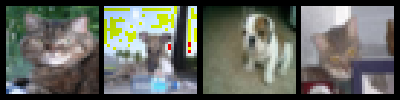

In [34]:
# 测试代码
dataiter = iter(testloader)
images, labels = next(dataiter)
print('实际的label: ', ' '.join(classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images/2-0.5)).resize((400, 100))

In [35]:
# 测试代码
outputs = net(V(images))
_, predicted = t.max(outputs.data, 1)
print('预测结果: ', ' '.join('%5s' %classes[predicted[j]] for j in range(4)))


预测结果:    cat  ship   cat truck


In [36]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outpus = net(V(images))
    _, predicted = t.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('10000张测试集中的准确率: %d %%' % (100 * correct / total))

10000张测试集中的准确率: 10 %


In [ ]:
from torchvision import models
model = models.vgg16(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4096, 2)
)

model